In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from quilt.data.ResidentMario import geoplot_data
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
from shapely.geometry import Point

In [2]:
armed_shootings_by_year = pd.read_csv('raw_data/armed_shootings_clean.csv')

armed_shootings_by_year.head()

,Unnamed: 0,Year,Name
0,0,2000,304
1,1,2001,339
2,2,2002,383
3,3,2003,419
4,4,2004,467


In [3]:
unarmed_shootings_by_year = pd.read_csv('raw_data/unarmed_shootings_clean.csv')

unarmed_shootings_by_year.head()

,Unnamed: 0,Year,Name
0,0,2000,12
1,1,2001,15
2,2,2002,22
3,3,2003,17
4,4,2004,16


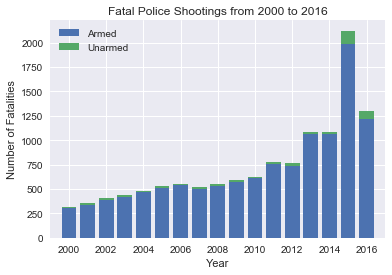

In [8]:
# Use Seaborn stylings
sns.set()

# Plot the number of fatalities by year
p1 = plt.bar(x = armed_shootings_by_year["Year"], height = armed_shootings_by_year["Name"], align = "center")
p2 = plt.bar(x = unarmed_shootings_by_year["Year"], height = unarmed_shootings_by_year["Name"],
       bottom = armed_shootings_by_year["Name"], align = "center")


# Add labels
plt.title("Fatal Police Shootings from 2000 to 2016")
plt.xlabel("Year")
plt.ylabel("Number of Fatalities")
plt.legend((p1[0], p2[0]), ('Armed', 'Unarmed'), loc='best')

# Set x limits
plt.xlim(1999,2017)

plt.show()

In [19]:
continental_usa = gpd.read_file(geoplot_data.contiguous_usa())
continental_usa = continental_usa.set_index("State")

lat_lng_df = pd.read_csv('raw_data/lat_long_states_fatalities.csv')

lat_lng_df.head()

,Unnamed: 0,state name,Fatalities,latitude,longitude
0,0,Alaska,73,64.0685,-52.2782
1,1,Alabama,326,32.7794,-86.8287
2,2,Arkansas,70,34.8938,-92.4426
3,3,Arizona,585,34.2744,-11.6602
4,4,California,2913,37.1841,-19.4696


In [20]:
geometry = [Point(xy) for xy in zip(lat_lng_df.longitude, lat_lng_df.latitude)]
lat_lng_df = lat_lng_df.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(lat_lng_df, crs=crs, geometry=geometry)

gdf.head()

,Unnamed: 0,state name,Fatalities,geometry
0,0,Alaska,73,POINT (-52.2782 64.0685)
1,1,Alabama,326,POINT (-86.8287 32.7794)
2,2,Arkansas,70,POINT (-92.4426 34.8938)
3,3,Arizona,585,POINT (-11.6602 34.2744)
4,4,California,2913,POINT (-19.4696 37.1841)


In [22]:
# Geopandas is limited to continental US, so exclude Alaska and Hawaii
gdf = gdf.loc[(gdf["state name"] != 'Alaska') & (gdf["state name"] != 'Hawaii')]

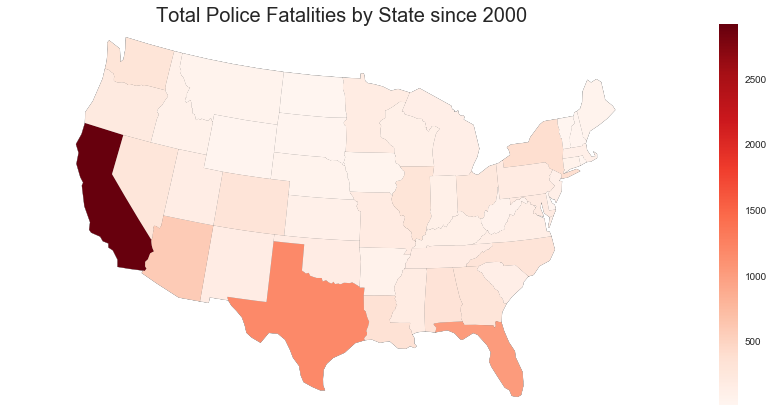

In [23]:
ax = gplt.polyplot(continental_usa, projection=gcrs.AlbersEqualArea(), figsize = (15,7))

gplt.aggplot(gdf, projection=gcrs.AlbersEqualArea(), hue='Fatalities', cmap='Reds',
             by='state name', geometry=continental_usa.geometry, ax=ax,
             linewidth=0)

plt.title("Total Police Fatalities by State since 2000", size = 20)

plt.show()

In [25]:
# Read in census data
census_df = pd.read_csv("raw_data/mean_populations_by_state.csv")

census_df.head()

,Unnamed: 0,state name,2010,2011,2012,2013,2014,2015,2016,2017,Mean Population
0,0,Alabama,4785579.0,4798649.0,4813946.0,4827660.0,4840037.0,4850858.0,4860545.0,4874747.0,4.831503e+06
1,1,Alaska,714015.0,722259.0,730825.0,736760.0,736759.0,737979.0,741522.0,739795.0,7.324892e+05
2,2,Arizona,6407002.0,6465488.0,6544211.0,6616124.0,6706435.0,6802262.0,6908642.0,7016270.0,6.683304e+06
3,3,Arkansas,2921737.0,2938640.0,2949208.0,2956780.0,2964800.0,2975626.0,2988231.0,3004279.0,2.962413e+06
4,4,California,37327690.0,37672654.0,38019006.0,38347383.0,38701278.0,39032444.0,39296476.0,39536653.0,3.849170e+07


In [26]:
# Join to our geoDF to adjust by population
merged_df = pd.merge(gdf, census_df, on="state name")[["state name", "Fatalities", "Mean Population", "geometry"]]

merged_df["Fatalities adjusted by Population"] = 100000*merged_df["Fatalities"]/merged_df["Mean Population"]

merged_df.head()

,state name,Fatalities,Mean Population,geometry,Fatalities adjusted by Population
0,Alabama,326,4.831503e+06,POINT (-86.8287 32.7794),6.747383
1,Arkansas,70,2.962413e+06,POINT (-92.4426 34.8938),2.362939
2,Arizona,585,6.683304e+06,POINT (-11.6602 34.2744),8.753155
3,California,2913,3.849170e+07,POINT (-19.4696 37.1841),7.567866
4,Colorado,310,5.316668e+06,POINT (-5.5478 38.9972),5.830720


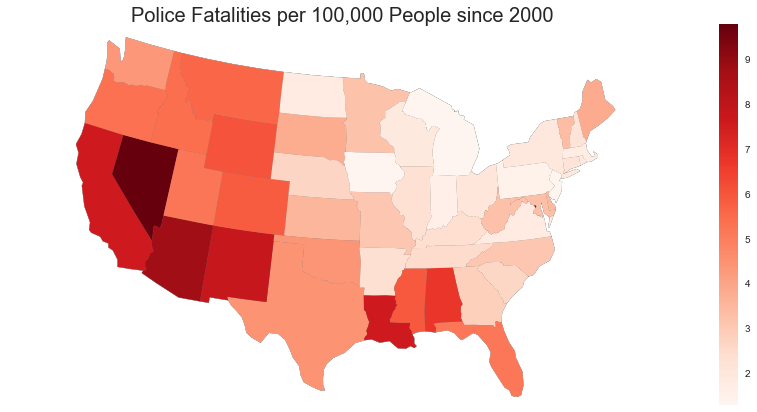

In [27]:
continental_usa = gpd.read_file(geoplot_data.contiguous_usa())
continental_usa = continental_usa.set_index("State")

ax = gplt.polyplot(continental_usa, projection=gcrs.AlbersEqualArea(), figsize = (15,7))

gplt.aggplot(merged_df, projection=gcrs.AlbersEqualArea(), hue='Fatalities adjusted by Population', cmap='Reds',
             by='state name', geometry=continental_usa.geometry, ax=ax, linewidth=0)

plt.title("Police Fatalities per 100,000 People since 2000", size = 20)

plt.show()

In [165]:
equip_df = pd.read_csv('raw_data/summary.csv')

equip_df.head()

,Unnamed: 0,Year,State,State_Ab,County,Item Name,Ship Date,NSN,Quantity,Total.Cost,psc,group,psc_desc,psc_category,group_desc,group_note,Lat,Lon
0,0,2006,ALABAMA,AL,AUTAUGA,"RIFLE,5.56 MILLIMETER",11/15/2006,1005-00-073-9421,4,1996.00,1005,10,Guns,through 30mm,Weapons,This group includes combat weapons as well as ...,32.450328,-86.721712
1,1,2006,ALABAMA,AL,BALDWIN,"PISTOL,CALIBER .45,AUTOMATIC",11/15/2006,1005-00-726-5655,24,1409.04,1005,10,Guns,through 30mm,Weapons,This group includes combat weapons as well as ...,30.763492,-87.756371
2,2,2006,ALABAMA,AL,BALDWIN,"RIFLE,5.56 MILLIMETER",11/15/2006,1005-00-073-9421,2,998.00,1005,10,Guns,through 30mm,Weapons,This group includes combat weapons as well as ...,30.763492,-87.756371
3,3,2006,ALABAMA,AL,BALDWIN,"RIFLE,5.56 MILLIMETER",4/15/2006,1005-00-073-9421,4,1996.00,1005,10,Guns,through 30mm,Weapons,This group includes combat weapons as well as ...,30.763492,-87.756371
4,4,2006,ALABAMA,AL,BALDWIN,"RIFLE,7.62 MILLIMETER",11/15/2006,1005-00-589-1271,10,1380.00,1005,10,Guns,through 30mm,Weapons,This group includes combat weapons as well as ...,30.763492,-87.756371


In [166]:
# Subset the data based on group_desc to produce subplots
weapons_df = equip_df.loc[equip_df["group_desc"] == "Weapons", :]

ammo_df = equip_df.loc[equip_df["group_desc"] == "Ammunition and Explosives", :]

missile_df = equip_df.loc[equip_df["group_desc"] == "Guided Missiles", :]

In [167]:
# Group the data so that we can produce visualizations based on quantity and cost
weapons_grouped_df = weapons_df.groupby(["County","State", "Lat", "Lon"])

weapons_grouped_df = weapons_grouped_df[["Quantity", "Total.Cost"]].sum().reset_index()

weapons_grouped_df.head()

,County,State,Lat,Lon,Quantity,Total.Cost
0,ACADIA,LOUISIANA,30.344615,-92.345888,22,5563.0
1,ADA,IDAHO,43.735179,-116.410330,32,12358.0
2,ADAIR,OKLAHOMA,35.900019,-94.640218,4,498.0
3,ADAMS,COLORADO,39.788286,-104.822765,41,11434.0
4,ADAMS,ILLINOIS,39.952413,-91.200676,45,8163.3


In [168]:
# Convert to GeoPandas
geometry = [Point(xy) for xy in zip(weapons_grouped_df.Lon, weapons_grouped_df.Lat)]
weapons_grouped_df = weapons_grouped_df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
weapons_geo = gpd.GeoDataFrame(weapons_grouped_df, crs=crs, geometry=geometry)

# Exclude non-contiguous US
weapons_geo = weapons_geo.loc[(weapons_geo["State"] != 'GUAM') &\
              (weapons_geo["State"] != 'VIRGIN ISLANDS'), :]

weapons_geo.head()

,County,State,Quantity,Total.Cost,geometry
0,ACADIA,LOUISIANA,22,5563.0,POINT (-92.345888 30.344615)
1,ADA,IDAHO,32,12358.0,POINT (-116.41033 43.735179)
2,ADAIR,OKLAHOMA,4,498.0,POINT (-94.640218 35.900019)
3,ADAMS,COLORADO,41,11434.0,POINT (-104.822765 39.788286)
4,ADAMS,ILLINOIS,45,8163.3,POINT (-91.200676 39.952413)


In [169]:
# Group the data so that we can produce visualizations based on quantity and cost
ammo_grouped_df = ammo_df.groupby(["County","State", "Lat", "Lon"])

ammo_grouped_df = ammo_grouped_df[["Quantity", "Total.Cost"]].sum().reset_index()

ammo_grouped_df.head()

,County,State,Lat,Lon,Quantity,Total.Cost
0,ALLEN,OHIO,40.772147,-84.047100,41,396031.4
1,ANCHORAGE,ALASKA,61.287624,-149.486981,1,10000.0
2,ANDERSON,SOUTH CAROLINA,34.492718,-82.638297,10,1140.0
3,ANDROSCOGGIN,MAINE,44.087422,-70.243848,1,10000.0
4,ARLINGTON,VIRGINIA,38.885484,-77.099113,10,100000.0


In [170]:
# Convert to GeoPandas
geometry = [Point(xy) for xy in zip(ammo_grouped_df.Lon, ammo_grouped_df.Lat)]
ammo_grouped_df = ammo_grouped_df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
ammo_geo = gpd.GeoDataFrame(ammo_grouped_df, crs=crs, geometry=geometry)

# Exclude non-contiguous US
ammo_geo = ammo_geo.loc[(ammo_geo["State"] != 'GUAM') &\
              (ammo_geo["State"] != 'VIRGIN ISLANDS'), :]

ammo_geo.head()

,County,State,Quantity,Total.Cost,geometry
0,ALLEN,OHIO,41,396031.4,POINT (-84.0471 40.772147)
1,ANCHORAGE,ALASKA,1,10000.0,POINT (-149.486981 61.287624)
2,ANDERSON,SOUTH CAROLINA,10,1140.0,POINT (-82.63829699999999 34.492718)
3,ANDROSCOGGIN,MAINE,1,10000.0,POINT (-70.243848 44.087422)
4,ARLINGTON,VIRGINIA,10,100000.0,POINT (-77.099113 38.88548400000001)


In [171]:
# Group the data so that we can produce visualizations based on quantity and cost
missile_grouped_df = missile_df.groupby(["County","State", "Lat", "Lon"])

missile_grouped_df = missile_grouped_df[["Quantity", "Total.Cost"]].sum().reset_index()

missile_grouped_df.head()

,County,State,Lat,Lon,Quantity,Total.Cost
0,DEER LODGE,MONTANA,46.158210,-113.009421,1,137814.00
1,FREMONT,COLORADO,38.477727,-105.507603,1,59000.00
2,SAINT CLAIR,ALABAMA,33.603543,-86.466833,2,148.06
3,VALLEY,MONTANA,48.019588,-106.446962,1,137814.00
4,VENTURA,CALIFORNIA,34.032383,-119.134300,10,1838.20


In [172]:
# Convert to GeoPandas
geometry = [Point(xy) for xy in zip(missile_grouped_df.Lon, missile_grouped_df.Lat)]
missile_grouped_df = missile_grouped_df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
missile_geo = gpd.GeoDataFrame(missile_grouped_df, crs=crs, geometry=geometry)

# Exclude non-contiguous US
missile_geo = missile_geo.loc[(missile_geo["State"] != 'GUAM') &\
              (missile_geo["State"] != 'VIRGIN ISLANDS'), :]

missile_geo.head()

,County,State,Quantity,Total.Cost,geometry
0,DEER LODGE,MONTANA,1,137814.00,POINT (-113.009421 46.15821)
1,FREMONT,COLORADO,1,59000.00,POINT (-105.507603 38.477727)
2,SAINT CLAIR,ALABAMA,2,148.06,POINT (-86.46683299999999 33.603543)
3,VALLEY,MONTANA,1,137814.00,POINT (-106.446962 48.019588)
4,VENTURA,CALIFORNIA,10,1838.20,POINT (-119.1343 34.032383)


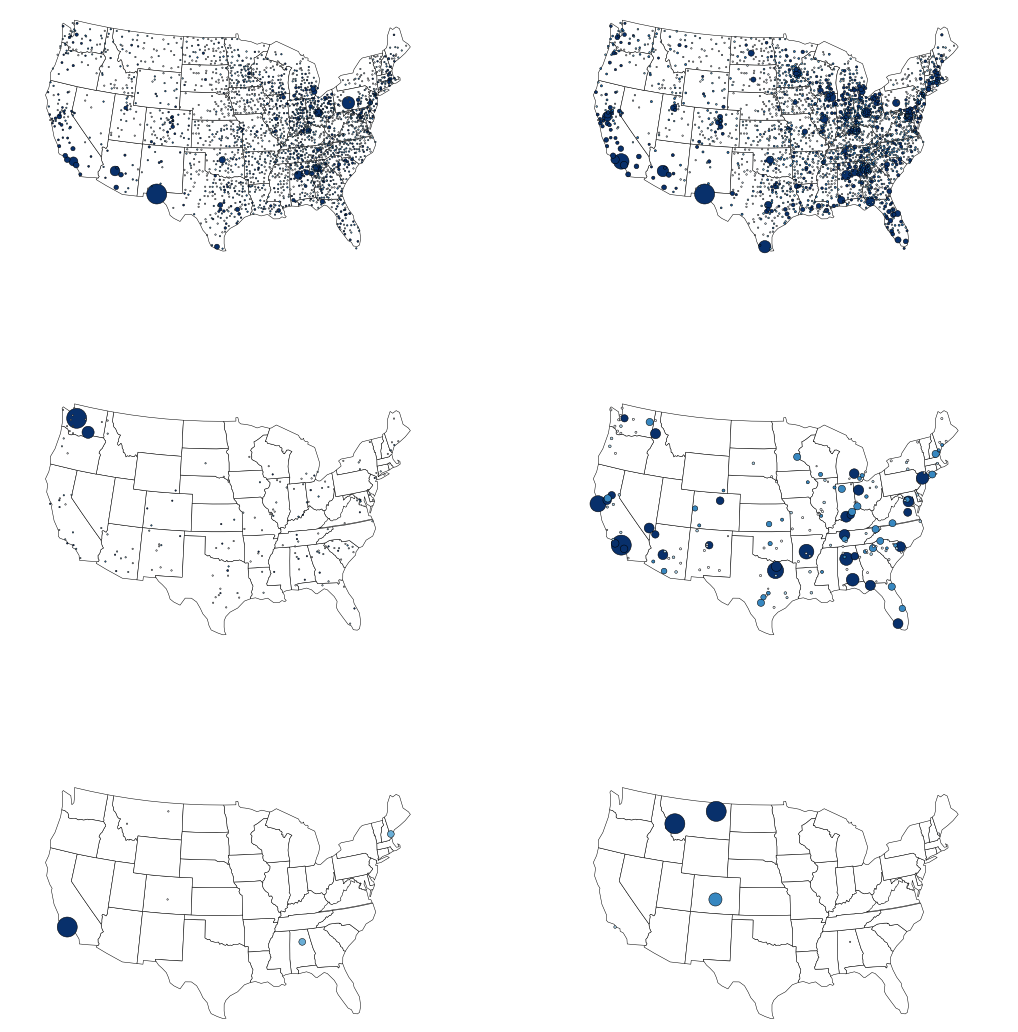

In [156]:
f, axarr = plt.subplots(3, 2, figsize=(18, 20), subplot_kw={
    'projection': gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)
})

polyplot_kwargs = {
    'projection': gcrs.AlbersEqualArea(), 'facecolor': 'white',
    'zorder': -100, 'linewidth': 0.5
}

# Plot quantity vs Weapons
gplt.polyplot(continental_usa, ax = axarr[0][0] ,**polyplot_kwargs)
gplt.pointplot(weapons_geo, projection=gcrs.AlbersEqualArea(), scale ='Quantity', linewidth = 0.5, ax = axarr[0][0],
               hue='Quantity', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (0.1,20))


# Plot cost vs Weapons
gplt.polyplot(continental_usa, ax = axarr[0][1] ,**polyplot_kwargs)
gplt.pointplot(weapons_geo, projection=gcrs.AlbersEqualArea(), scale ='Total.Cost', linewidth = 0.5, ax = axarr[0][1],
               hue='Total.Cost', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (0.1,20))


# Plot quantity vs Ammo
gplt.polyplot(continental_usa, ax = axarr[1][0] ,**polyplot_kwargs)
gplt.pointplot(ammo_geo, projection=gcrs.AlbersEqualArea(), scale ='Quantity', linewidth = 0.5, ax = axarr[1][0],
               hue='Quantity', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (0.1,20))


# Plot cost vs Ammo
gplt.polyplot(continental_usa, ax = axarr[1][1] ,**polyplot_kwargs)
gplt.pointplot(ammo_geo, projection=gcrs.AlbersEqualArea(), scale ='Total.Cost', linewidth = 0.5, ax = axarr[1][1],
               hue='Total.Cost', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (0.1,20))


# Plot quantity vs Missiles
gplt.polyplot(continental_usa, ax = axarr[2][0] ,**polyplot_kwargs)
gplt.pointplot(missile_geo, projection=gcrs.AlbersEqualArea(), scale ='Quantity', linewidth = 0.5, ax = axarr[2][0],
               hue='Quantity', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (0.1,20))


# Plot cost vs Missiles
gplt.polyplot(continental_usa, ax = axarr[2][1] ,**polyplot_kwargs)
gplt.pointplot(missile_geo, projection=gcrs.AlbersEqualArea(), scale ='Total.Cost', linewidth = 0.5, ax = axarr[2][1],
               hue='Total.Cost', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (0.1,20))


plt.show()

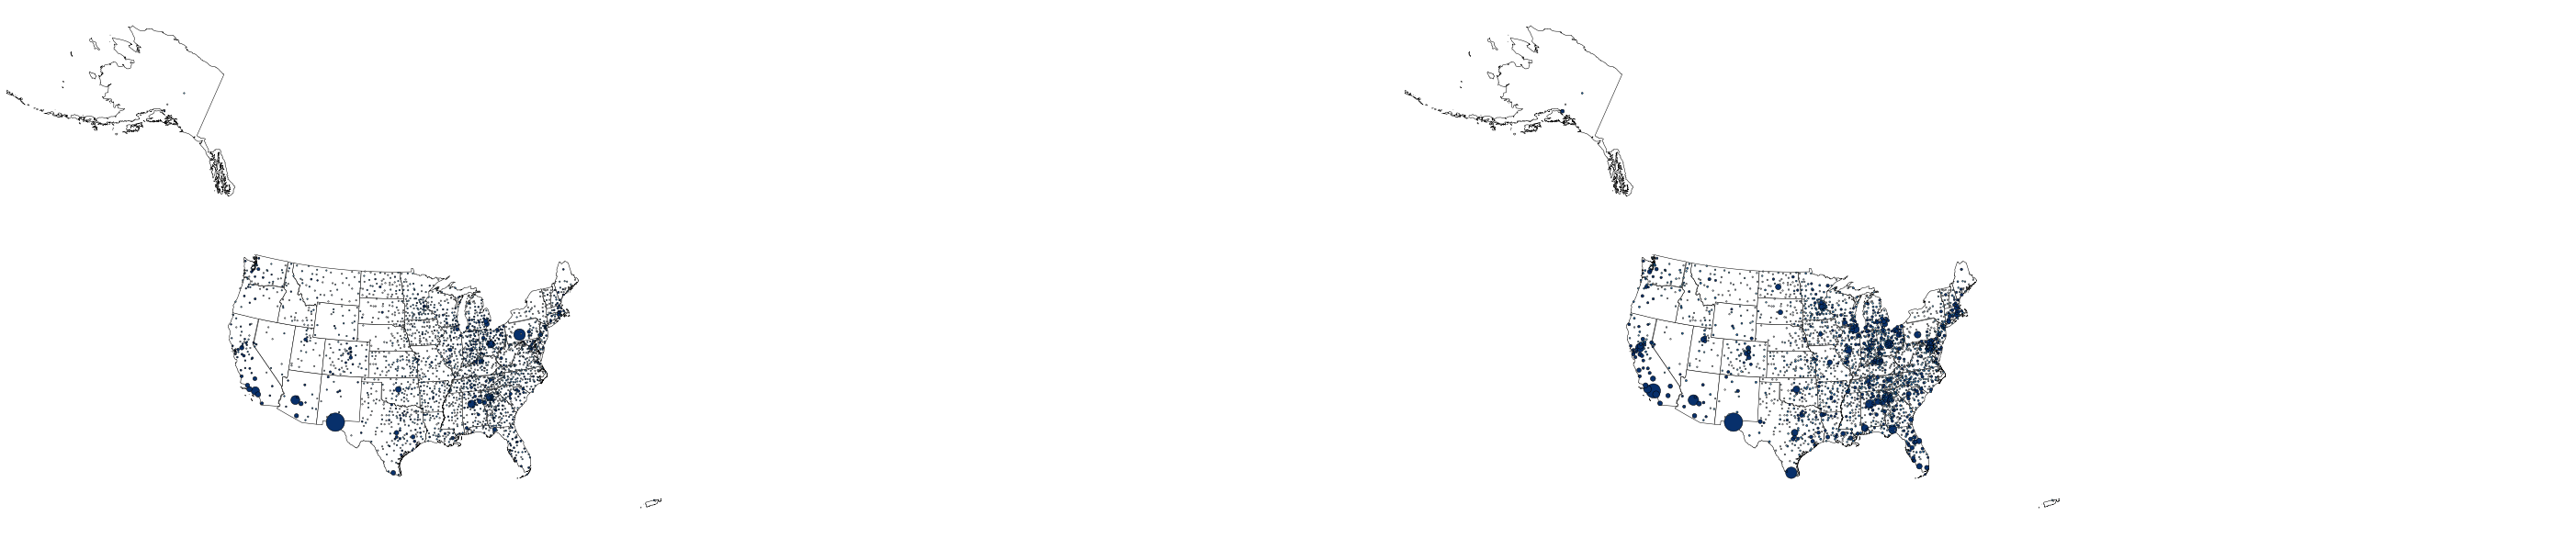

In [226]:
total_usa = gpd.read_file('raw_data/gz_2010_us_040_00_500k.json')   

f, axarr = plt.subplots(1, 2, figsize=(50, 50), subplot_kw={
    'projection': gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)
})

polyplot_kwargs = {
    'projection': gcrs.AlbersEqualArea(), 'facecolor': 'white',
    'zorder': -100, 'linewidth': 0.5
}
xlim = [-5000000,10000000]
ylim = [-2410140.0359920366, 4500000]


# Plot quantity vs Weapons
gplt.polyplot(total_usa, ax = axarr[0] ,**polyplot_kwargs)
gplt.pointplot(weapons_geo, projection=gcrs.AlbersEqualArea(), scale ='Quantity', linewidth = 0.5, ax = axarr[0],
               hue='Quantity', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (0.1,20))
axarr[0].set_xlim(xlim)
axarr[0].set_ylim(ylim)

# Plot cost vs Weapons
gplt.polyplot(total_usa, ax = axarr[1] ,**polyplot_kwargs)
gplt.pointplot(weapons_geo, projection=gcrs.AlbersEqualArea(), scale ='Total.Cost', linewidth = 0.5, ax = axarr[1],
               hue='Total.Cost', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (0.1,20))
axarr[1].set_xlim(xlim)
axarr[1].set_ylim(ylim)


plt.show()

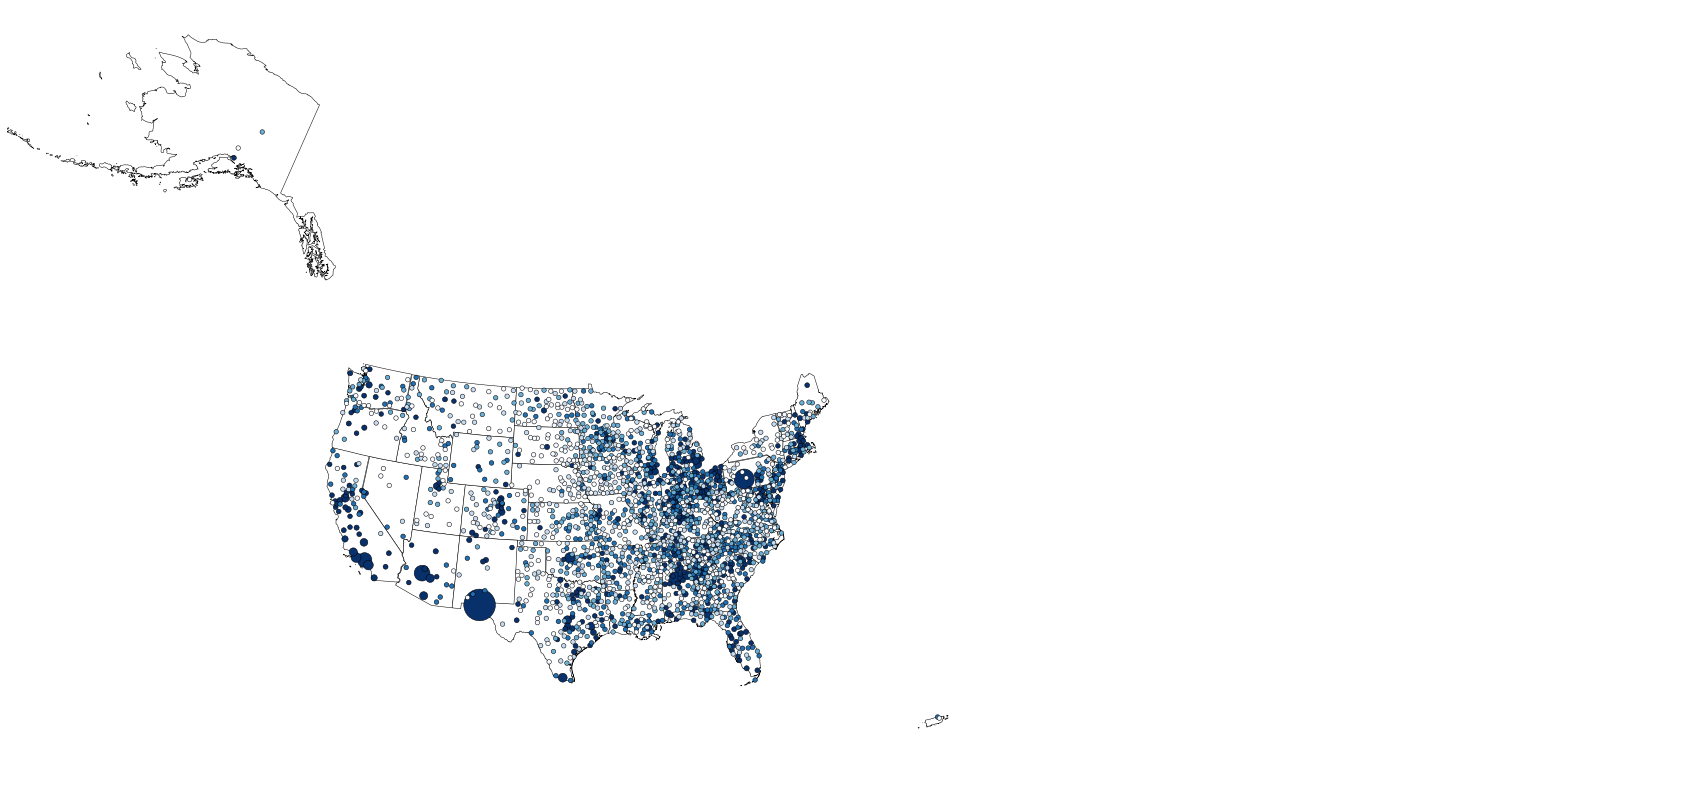

In [243]:
total_usa = gpd.read_file('raw_data/gz_2010_us_040_00_500k.json')   

polyplot_kwargs = {
    'projection': gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5), 'facecolor': 'white',
    'zorder': -100, 'linewidth': 0.5
}
xlim = [-5000000,10000000]
ylim = [-2410140.0359920366, 4500000]


# Plot quantity vs Weapons
ax = gplt.polyplot(total_usa, **polyplot_kwargs, figsize = (30,20))
gplt.pointplot(weapons_geo, projection=gcrs.AlbersEqualArea(), scale ='Quantity', linewidth = 0.5, ax = ax,
               hue='Quantity', cmap='Blues', alpha = 1, edgecolor = 'black', limits = (1,50), figsize = (30,20))
plt.xlim(xlim)
plt.ylim(ylim)

plt.savefig('test.png')

plt.show()